# Import pacchetti e caricamento del dataset

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from IPython.display import clear_output

from scipy.io import arff
from google.colab import drive

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
import scipy.stats as st

In [2]:
drive.mount('/content/drive')

filepath = 'drive/MyDrive/colab_datasets/Dry_Bean_Dataset.arff'

try:
    data = arff.loadarff(filepath)
    df = pd.DataFrame(data[0])
except FileNotFoundError:
    print(f"Error: File not found at {filepath}")
except Exception as e:
    print(f"An error occurred: {e}")

Mounted at /content/drive


# Analisi del dataset

## Data Exploration
Innanzitutto si può osservare che il dataset non presenta feature categoriche, e quindi non è necessario adottare alcuna misura per gestirle.
Non sono inoltre presenti istanze con valori mancanti.

Si osserva però che il target, ovvero la classe a cui appartiene ogni istanza, è espressa come un nome di fagiolo, e non come un intero. Serve quindi effettuare il label encoding del target.

In [3]:
label_encoder = LabelEncoder()
label_encoder.fit(df["Class"])
le_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_mapping)
df["Class"] = label_encoder.transform(df["Class"])

{b'BARBUNYA': 0, b'BOMBAY': 1, b'CALI': 2, b'DERMASON': 3, b'HOROZ': 4, b'SEKER': 5, b'SIRA': 6}


Si verifica poi se le classi sono bilanciate.

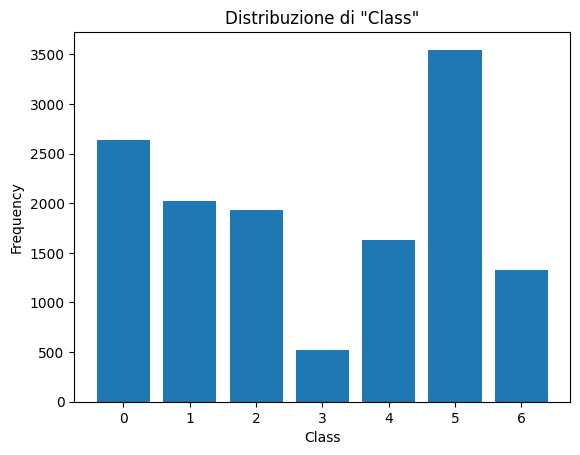

In [4]:
plt.bar(df["Class"].unique(), df["Class"].value_counts())
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Distribuzione di \"Class\"")
plt.xticks(df["Class"].unique())
plt.show()

Si può notare che le classi non sono bilanciate, soprattutto la 3 e la 5. Non potranno essere quindi usate metriche di performance che non tengono conto di diversi costi di errore per le classi, come l'accuratezza, ma sarà necessario usare metriche come precisione, richiamo, f1-score e accuratezza bilanciata. Si dovranno inoltre preferire metriche di macro-performance a quelle di micro-performance.

Si può osservare poi che due particolari feature del dataset sono superflue: ConvexArea e Area. Esse, infatti, dipendono fortemente dalla distanza da cui
il fagiolo è stato inquadrato (ovviamente un fagiolo più vicino all'obiettivo
avrà un area maggiore), e la classificazione non dipende logicamente dal loro valore.
Ha però senso analizzare il rapporto tra queste due feature, ovvero quanta area
della ConvexArea è effettivamente occupata dal fagiolo: questo dato, infatti,
rimane più o meno invariato al variare della distanza da cui il fagiolo è
inquadrato.
Questo dato è però già espresso dalla feature AspectRation, e si possono quindi
scartare le sole due feature Area e ConvexArea.

In [5]:
df.drop(columns=["Area", "ConvexArea", "MajorAxisLength", "MinorAxisLength"], axis=1, inplace=True)

## Standardizzazione e PCA
Si procede ora con la standardizzazione delle feature numeriche continue sulle sole istanze di training, ovvero far sì che ognuna di esse abbia media 0 e deviazione standard 1. Questo passaggio è necessario per poter applicare poi PCA (sempre solo sulle istanze di training), in quanto PCA è sensibile a feature con diverse scale (una feature con una scala più ampia ha infatti molto spesso una varianza maggiore, influendo quindi sulla PCA). (PCA è utile quando le feature sono fortemente correlate, come avviene nel caso dei fagioli, e anche quando il dataset è grande, come in questo caso).
Tutte le feature sono continue (le uniche due intere sono state scartate, in quanto superflue) e quindi tutte possono essere standardizzate.

In [6]:
target_name = "Class"
feature_names = list(set(df.columns) - set([target_name]))

In [7]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df[feature_names])

pca = PCA(0.95)
pca_data = pca.fit_transform(scaled)

Le componenti principali considerate hanno le seguenti percentuali di varianza spiegata.

In [8]:
print(pca.explained_variance_ratio_)

[0.55920697 0.21313121 0.10377257 0.06733812 0.03552743]


I pesi di ogni feature per le componenti principali considerate sono i seguenti:

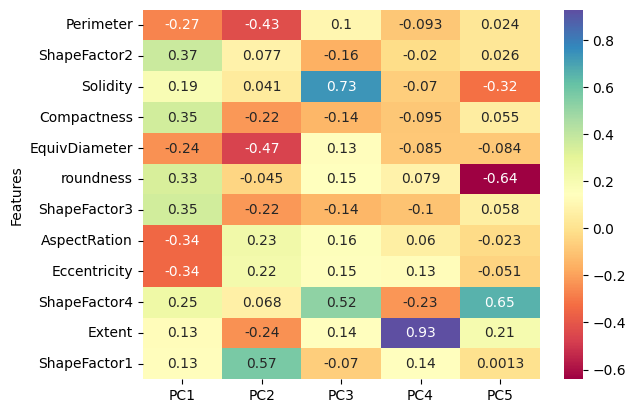

In [9]:
pc_names = ["PC"+str(i) for i in list(range(1, pca.n_features_in_+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_names, pca.components_)))
loadings_df['Features'] = feature_names
loadings_df = loadings_df.set_index('Features')
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

## Splitting del dataset
Si procede poi con la suddivisione del dataset in istanze di training e istanze di test, in modo tale da mantenere intaccata una parte del dataset per la futura verifica del modello.

Siccome il dataset è di medie dimensioni, la percentuale di istanze dedicate al test deve essere compresa tra 20% e 40%. In questo caso si è scelto di dedicare il 25% di istanze del dataset al test.

Proprio perchè il dataset contiene numerose istanze, inoltre, non sarà necessario alcun tipo di repeated holdout, ma basterà semplicemente addestrare i vari modelli con il solo partizionamento del dataset individuato.

In [10]:
train_inst, test_inst, train_targets, test_targets = train_test_split(pca_data, df[target_name], test_size=0.25, random_state=42)

print(f"Numero di istanze nel training set: {train_inst.shape[0]}")
print(f"Numero di istanze nel test set: {test_inst.shape[0]}")

Numero di istanze nel training set: 10208
Numero di istanze nel test set: 3403


# Addestramento dei modelli

## Albero decisionale

Per trovare i parametri migliori per l'albero decisionale viene effettuata una grid search, utilizzando l'accuratezza bilanciata come criterio di scoring a causa dello sbilanciamento del dataset.

Si ricorda che normalmente gli alberi decisionali trattano feature discrete, e per trattare feature continue è necessario apportare alcune modifiche. Questo caso particolare viene automaticamente gestito da DecisionTreeClassifier.

Per limitare la complessità dell'albero vengono valutati anche parametri come profondità massima e numero massimo di foglie.


In [11]:
tree_clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)

tree_param = {
    'criterion':('gini', 'entropy'),
    'max_depth':[6, 8, 10],
    'max_leaf_nodes':[20, 25, 35]
}
tree_grid = GridSearchCV(tree_clf, tree_param, scoring="balanced_accuracy", refit=True)
tree_grid.fit(train_inst, train_targets)

print("Parametri migliori: ", tree_grid.best_params_)

Parametri migliori:  {'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 35}


Si verificano le performance del modello trovato usando la porzione di dataset riservata al testing.



Balanced accuracy:  0.9121207940124937


               precision    recall  f1-score   support

           0       0.93      0.85      0.89       344
           1       0.99      0.99      0.99       142
           2       0.86      0.94      0.90       402
           3       0.91      0.86      0.89       851
           4       0.95      0.95      0.95       486
           5       0.92      0.93      0.92       513
           6       0.82      0.86      0.84       665

    accuracy                           0.90      3403
   macro avg       0.91      0.91      0.91      3403
weighted avg       0.90      0.90      0.90      3403



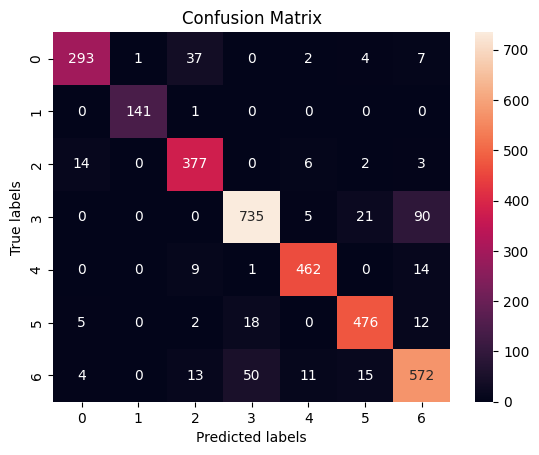

In [12]:
tree_pred = tree_grid.predict(test_inst)

tree_cm = confusion_matrix(test_targets, tree_pred)
ax= plt.subplot()
sns.heatmap(tree_cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

print("\n\nBalanced accuracy: ", balanced_accuracy_score(test_targets, tree_pred))
print("\n\n", classification_report(test_targets, tree_pred))

## Rete neurale (Multi-Layer Perceptron)


Per trovare i parametri migliori per il Multi Layer Perceptron viene effettuata una grid search, utilizzando l'accuratezza bilanciata come criterio di scoring a causa dello sbilanciamento del dataset.

In [13]:
mlp_clf = MLPClassifier(solver='adam', random_state=42)

mlp_param = {
    'hidden_layer_sizes': [(5, 5), (10)],
    'activation': ['tanh', 'relu']
}
mlp_grid = GridSearchCV(mlp_clf, mlp_param, n_jobs= -1, scoring="balanced_accuracy", refit=True)
mlp_grid.fit(train_inst, train_targets)

clear_output()
print("Parametri migliori: ", mlp_grid.best_params_)

Parametri migliori:  {'activation': 'relu', 'hidden_layer_sizes': 10}


Si verificano le performance del modello trovato usando la porzione di dataset riservata al testing.



Balanced accuracy:  0.9365264931680762


               precision    recall  f1-score   support

           0       0.91      0.92      0.92       344
           1       1.00      1.00      1.00       142
           2       0.94      0.94      0.94       402
           3       0.92      0.91      0.91       851
           4       0.97      0.96      0.96       486
           5       0.95      0.93      0.94       513
           6       0.87      0.89      0.88       665

    accuracy                           0.93      3403
   macro avg       0.94      0.94      0.94      3403
weighted avg       0.93      0.93      0.93      3403



Text(0.5, 1.0, 'Confusion Matrix')

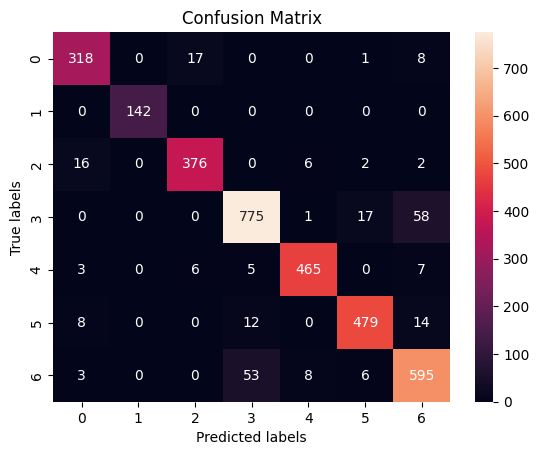

In [14]:
mlp_pred = mlp_grid.predict(test_inst)
print("\n\nBalanced accuracy: ", balanced_accuracy_score(test_targets, mlp_pred))
print("\n\n", classification_report(test_targets, mlp_pred))

cm_low = confusion_matrix(test_targets, mlp_pred)
ax= plt.subplot()
sns.heatmap(cm_low, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

Analizzando la loss curve del modello trovato si assesta quando raggiunge valori piccoli, di fatto non riuscendo a migliorare le performance del modello. Di conseguenza, il modello richiede inutilmente un alto tempo di addestramento e tende ad andare in overfitting.

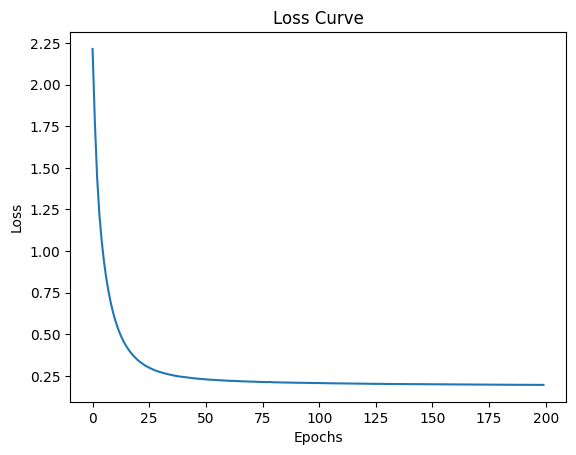

In [15]:
plt.plot(list(range(0, mlp_grid.best_estimator_.n_iter_)), mlp_grid.best_estimator_.loss_curve_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

Per ridurre il numero di epoche eseguite ma mantenendo performance simili, il modello trovato viene riaddestrato utilizzando una tolleranza maggiore.
Si rianalizzano poi le performance del modello con tolleranza maggiore.



Balanced accuracy:  0.9340412276693394


               precision    recall  f1-score   support

           0       0.92      0.92      0.92       344
           1       0.99      1.00      1.00       142
           2       0.94      0.93      0.93       402
           3       0.91      0.91      0.91       851
           4       0.97      0.96      0.96       486
           5       0.95      0.93      0.94       513
           6       0.86      0.89      0.88       665

    accuracy                           0.92      3403
   macro avg       0.94      0.93      0.93      3403
weighted avg       0.92      0.92      0.92      3403



Text(0.5, 1.0, 'Confusion Matrix')

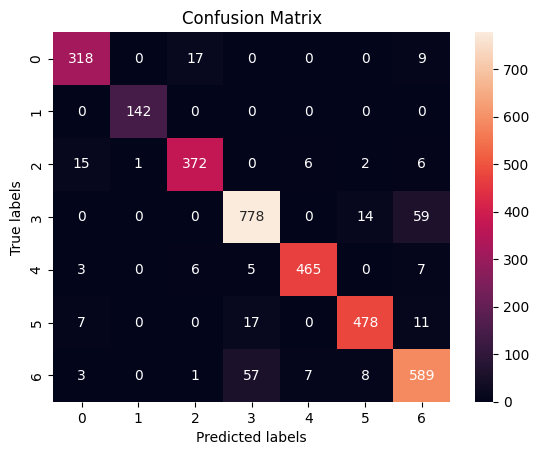

In [16]:
mlp_tolerance = 0.001

high_tol_mlp = MLPClassifier()
high_tol_params = mlp_grid.best_estimator_.get_params()
high_tol_params.update({"tol":mlp_tolerance})
high_tol_mlp.set_params(**high_tol_params)
high_tol_mlp.fit(train_inst, train_targets)

mlp_high_pred = high_tol_mlp.predict(test_inst)
print("\n\nBalanced accuracy: ", balanced_accuracy_score(test_targets, mlp_high_pred))
print("\n\n", classification_report(test_targets, mlp_high_pred))


cm_high = confusion_matrix(test_targets, mlp_high_pred)
ax= plt.subplot()
sns.heatmap(cm_high, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

Si può ora notare, analizzando la loss curve, che la loss curve tende ad assestarsi meno su piccoli valori di loss e che il numero di epoche richieste si è ridotto.

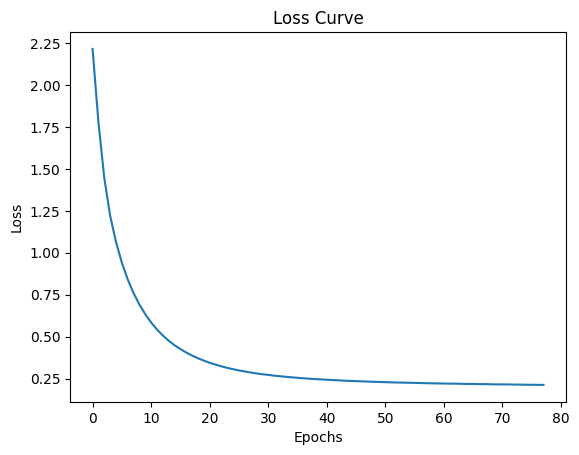

In [17]:
plt.plot(list(range(0, high_tol_mlp.n_iter_)), high_tol_mlp.loss_curve_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

## SVM

Per trovare i parametri migliori per la SVM viene effettuata una grid search, utilizzando l'accuratezza bilanciata come criterio di scoring a causa dello sbilanciamento del dataset.

Si ricorda che alti valori di C aumentano la complessità della SVM e tollerano meno errori.

In [18]:
svc = svm.SVC(class_weight='balanced', random_state=42)

svm_param = {
    'kernel':('linear', 'poly', 'rbf'),
    'C':[1, 2, 5]
}
svm_grid = GridSearchCV(svc, svm_param, scoring="balanced_accuracy", refit=True)
svm_grid.fit(train_inst, train_targets)

print("Parametri migliori: ", svm_grid.best_params_)

Parametri migliori:  {'C': 2, 'kernel': 'rbf'}


Si verificano le performance del modello trovato usando la porzione di dataset riservata al testing.



Balanced accuracy:  0.9419461886101822


               precision    recall  f1-score   support

           0       0.93      0.94      0.93       344
           1       1.00      1.00      1.00       142
           2       0.94      0.94      0.94       402
           3       0.93      0.90      0.92       851
           4       0.97      0.96      0.97       486
           5       0.94      0.95      0.95       513
           6       0.87      0.91      0.89       665

    accuracy                           0.93      3403
   macro avg       0.94      0.94      0.94      3403
weighted avg       0.93      0.93      0.93      3403



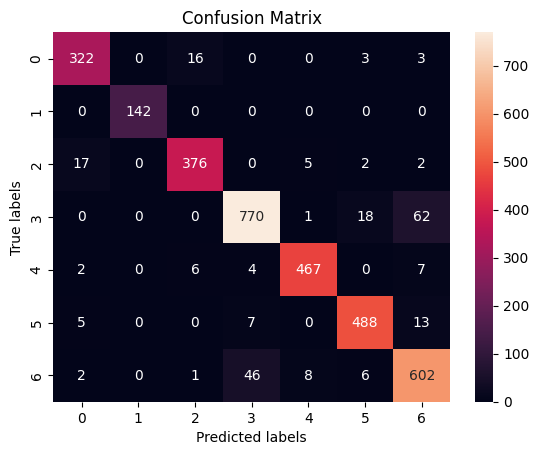

In [19]:
svm_pred = svm_grid.predict(test_inst)

svm_cm = confusion_matrix(test_targets, svm_pred)
ax= plt.subplot()
sns.heatmap(svm_cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

print("\n\nBalanced accuracy: ", balanced_accuracy_score(test_targets, svm_pred))
print("\n\n", classification_report(test_targets, svm_pred))

In [20]:
print(f"Numero di vettori di supporto: {svm_grid.best_estimator_.support_vectors_.shape[0]}")

Numero di vettori di supporto: 2151


## Gaussian Naive Bayes

Per utilizzare il Gaussian Naive Bayes bisogna però fare innanzitutto un'assunzione: tutte le feature devono essere sono conidizionalmente indipendenti. Le feature dovrebbero anche avere una distribuzione normale.
Nel caso delle componenti principali scelte tramite PCA, tutte, escluse la prima e la seconda, hanno una distribuzione normale. Anche la prima e la seconda si possono comunque assumere normali, in modo tale da poter applicare ugualmente il classificatore gaussiano.

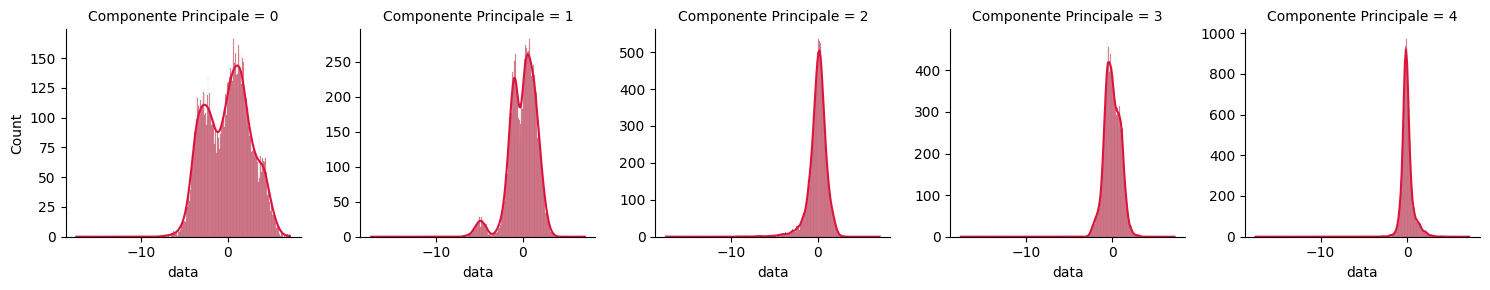

In [21]:
tmp_df = pd.DataFrame(pca_data).melt(var_name='Componente Principale', value_name='data')
sns.displot(data=tmp_df,
            x="data", col="Componente Principale", kde=True, color='crimson', height=3,
            facet_kws={"sharey": False, "sharex": False})

Il Gaussian Naive Bayes viene addestrato con le istanze di addestramento.



In [22]:
gnb_clf = GaussianNB()

gnb_clf.fit(train_inst, train_targets)

GaussianNB()

Si verificano le performance del modello usando la porzione di dataset riservata al testing.



Balanced accuracy:  0.921760794383231


               precision    recall  f1-score   support

           0       0.93      0.89      0.91       344
           1       1.00      1.00      1.00       142
           2       0.92      0.93      0.92       402
           3       0.92      0.87      0.89       851
           4       0.92      0.96      0.94       486
           5       0.95      0.93      0.94       513
           6       0.82      0.87      0.84       665

    accuracy                           0.91      3403
   macro avg       0.92      0.92      0.92      3403
weighted avg       0.91      0.91      0.91      3403



Text(0.5, 1.0, 'Confusion Matrix')

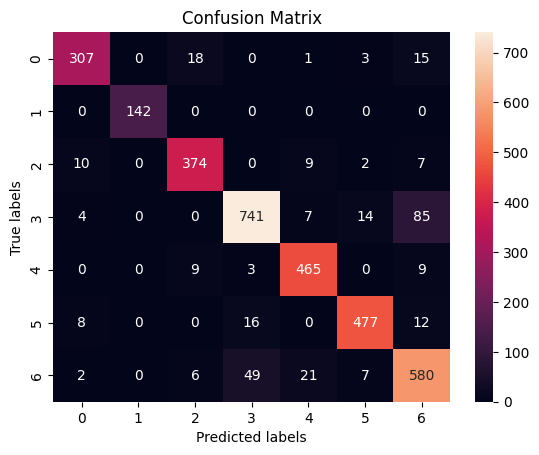

In [23]:
gnb_pred = gnb_clf.predict(test_inst)

print("\n\nBalanced accuracy: ", balanced_accuracy_score(test_targets, gnb_pred))
print("\n\n", classification_report(test_targets, gnb_pred))

gnb_cm = confusion_matrix(test_targets, gnb_pred)
ax= plt.subplot()
sns.heatmap(gnb_cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Confronto tra modelli

Per confrontare i modelli considerati vengono analizzati l'accuratezza bilanciata e il loro tempo di addestramento.

Per farlo, viene effettuata una stratified cross-validation con 10 fold, e i relativi risultati vengono salvati, per ogni modello, in un array di accuratezze bilanciate e un array di tempi di addestramento.

In [24]:
n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

Effettua la stratified 10-fold cross-validation dell'albero decisionale.

In [25]:
tree_stratified = []
tree_time = []

for n_fold, (train_ids, test_ids) in enumerate(folds.split(pca_data, df[target_name])):
        cv_train_inst, cv_test_inst = pca_data[train_ids], pca_data[test_ids]
        cv_train_targets, cv_test_targets = df[target_name][train_ids], df[target_name][test_ids]

        tree_model = DecisionTreeClassifier(random_state=42)
        tree_model.set_params(**tree_grid.best_estimator_.get_params())
        tree_start = time()
        tree_model.fit(cv_train_inst, cv_train_targets)
        tree_time.append(time() - tree_start)

        cv_tree_pred = tree_model.predict(cv_test_inst)
        tree_stratified.append(balanced_accuracy_score(cv_test_targets, cv_tree_pred))

Effettua la stratified 10-fold cross-validation del MLP.

In [26]:
mlp_stratified = []
mlp_time = []

for n_fold, (train_ids, test_ids) in enumerate(folds.split(pca_data, df[target_name])):
    cv_train_inst, cv_test_inst = pca_data[train_ids], pca_data[test_ids]
    cv_train_targets, cv_test_targets = df[target_name][train_ids], df[target_name][test_ids]

    mlp_model = MLPClassifier(random_state=42)
    mlp_params = mlp_grid.best_estimator_.get_params()
    mlp_params.update({"tol":mlp_tolerance})
    mlp_model.set_params(**mlp_params)
    mlp_start = time()
    mlp_model.fit(cv_train_inst, cv_train_targets)
    mlp_time.append(time() - mlp_start)

    cv_mlp_pred = mlp_model.predict(cv_test_inst)
    mlp_stratified.append(balanced_accuracy_score(cv_test_targets, cv_mlp_pred))

    clear_output()

Effettua la stratified 10-fold cross-validation della SVM.

In [27]:
svm_stratified = []
svm_time = []

for n_fold, (train_ids, test_ids) in enumerate(folds.split(pca_data, df[target_name])):
    cv_train_inst, cv_test_inst = pca_data[train_ids], pca_data[test_ids]
    cv_train_targets, cv_test_targets = df[target_name][train_ids], df[target_name][test_ids]

    svm_model = svm.SVC(random_state=42)
    svm_model.set_params(**svm_grid.best_estimator_.get_params())
    svm_start = time()
    svm_model.fit(cv_train_inst, cv_train_targets)
    svm_time.append(time() - svm_start)

    cv_svm_pred = svm_model.predict(cv_test_inst)
    svm_stratified.append(balanced_accuracy_score(cv_test_targets, cv_svm_pred))

Effettua la stratified 10-fold cross-validation del Gaussian Naive Bayes classifier.

In [28]:
gnb_stratified = []
gnb_time = []

for n_fold, (train_ids, test_ids) in enumerate(folds.split(pca_data, df[target_name])):
    cv_train_inst, cv_test_inst = pca_data[train_ids], pca_data[test_ids]
    cv_train_targets, cv_test_targets = df[target_name][train_ids], df[target_name][test_ids]

    gnb_model = GaussianNB()
    gnb_model.set_params(**gnb_clf.get_params())
    gnb_start = time()
    gnb_model.fit(cv_train_inst, cv_train_targets)
    gnb_time.append(time() - gnb_start)

    cv_gnb_pred = gnb_model.predict(cv_test_inst)
    gnb_stratified.append(balanced_accuracy_score(cv_test_targets, cv_gnb_pred))

Una volta memorizzate tutte le accuratezze bilanciate per ogni modello, è possibile calcolare, per ogni modello, un intervallo di confidenza dell'accuratezza bilanciata utilizzando il test t-student.
Gli intervalli di confidenza qui calcolati sono al 90%.

In [29]:
perf_confidence = 0.90

st_perf_tree = st.t.interval(confidence=perf_confidence, df=len(tree_stratified)-1, loc=np.mean(tree_stratified), scale=st.sem(tree_stratified))
st_perf_mlp = st.t.interval(confidence=perf_confidence, df=len(mlp_stratified)-1, loc=np.mean(mlp_stratified), scale=st.sem(mlp_stratified))
st_perf_svm = st.t.interval(confidence=perf_confidence, df=len(svm_stratified)-1, loc=np.mean(svm_stratified), scale=st.sem(svm_stratified))
st_perf_gnb = st.t.interval(confidence=perf_confidence, df=len(gnb_stratified)-1, loc=np.mean(gnb_stratified), scale=st.sem(gnb_stratified))

Una volta memorizzati tutti i tempi di esecuzione per ogni modello, è possibile calcolare, per ogni modello, un intervallo di confidenza del tempo di esecuzione utilizzando il test t-student.
Gli intervalli di confidenza qui calcolati sono al 90%.

In [30]:
time_confidence = 0.90

st_time_tree = st.t.interval(confidence=time_confidence, df=len(tree_time)-1, loc=np.mean(tree_time), scale=st.sem(tree_time))
st_time_mlp = st.t.interval(confidence=time_confidence, df=len(mlp_time)-1, loc=np.mean(mlp_time), scale=st.sem(mlp_time))
st_time_svm = st.t.interval(confidence=time_confidence, df=len(svm_time)-1, loc=np.mean(svm_time), scale=st.sem(svm_time))
st_time_gnb = st.t.interval(confidence=time_confidence, df=len(gnb_time)-1, loc=np.mean(gnb_time), scale=st.sem(gnb_time))

Si possono ora mostrare tutti i risultati di performance e tempi di esecuzione su tutti i modelli considerati.

In [31]:
print("Valore medio della balanced_accuracy\n")
print("Albero decisionale ---- " + str(np.mean(tree_stratified)))
print("Rete neurale ---------- " + str(np.mean(mlp_stratified)))
print("SVM ------------------- " + str(np.mean(svm_stratified)))
print("Gaussian Naive Bayes -- " + str(np.mean(gnb_stratified)))

print("\n\n")

print("Intervallo di confidenza al {:.0f}% per la balanced_accuracy\n".format(perf_confidence * 100))
print("Albero decisionale ---- " + str(st_perf_tree))
print("Rete neurale ---------- " + str(st_perf_mlp))
print("SVM ------------------- " + str(st_perf_svm))
print("Gaussian Naive Bayes -- " + str(st_perf_gnb))

print("\n\n")

print("Tempo di addestramento medio dei modelli (in millisecondi)\n")
print("Albero decisionale ---- {:.0f}".format(np.mean(tree_time) * 1000))
print("Rete neurale ---------- {:.0f}".format(np.mean(mlp_time) * 1000))
print("SVM ------------------- {:.0f}".format(np.mean(svm_time) * 1000))
print("Gaussian Naive Bayes -- {:.0f}".format(np.mean(gnb_time) * 1000))

print("\n\n")

print("Intervallo di confidenza al {:.0f}% per il tempo di esecuzione (in millisecondi)\n".format(time_confidence * 100))
print("Albero decisionale ---- ({:.0f}, {:.0f})".format(st_time_tree[0] * 1000, st_time_tree[1] * 1000))
print("Rete neurale ---------- ({:.0f}, {:.0f})".format(st_time_mlp[0] * 1000, st_time_mlp[1] * 1000))
print("SVM ------------------- ({:.0f}, {:.0f})".format(st_time_svm[0] * 1000, st_time_svm[1] * 1000))
print("Gaussian Naive Bayes -- ({:.0f}, {:.0f})".format(st_time_gnb[0] * 1000, st_time_gnb[1] * 1000))

Valore medio della balanced_accuracy

Albero decisionale ---- 0.9149655097888137
Rete neurale ---------- 0.9308022943997478
SVM ------------------- 0.9392469414174801
Gaussian Naive Bayes -- 0.9147909978656342



Intervallo di confidenza al 90% per la balanced_accuracy

Albero decisionale ---- (0.91070264323751, 0.9192283763401174)
Rete neurale ---------- (0.9270011120008699, 0.9346034767986258)
SVM ------------------- (0.9371000704650237, 0.9413938123699365)
Gaussian Naive Bayes -- (0.9116876803515916, 0.9178943153796768)



Tempo di addestramento medio dei modelli (in millisecondi)

Albero decisionale ---- 81
Rete neurale ---------- 1715
SVM ------------------- 857
Gaussian Naive Bayes -- 7



Intervallo di confidenza al 90% per il tempo di esecuzione (in millisecondi)

Albero decisionale ---- (79, 83)
Rete neurale ---------- (1506, 1925)
SVM ------------------- (744, 970)
Gaussian Naive Bayes -- (6, 7)


Dalle misurazioni è possibile ridurre la scelta del modello migliore a due soli modelli: SVM e Gaussian Naive Bayes. Se il dominio richiede un'accuratezza bilanciata massima, allora il modello migliore è la SVM, e sarà necessario tempi di addestramento più lunghi.
Se invece il dominio permette di tollerare una percentuale maggiore di errori, allora il modello migliore è il Gaussian Naive Bayes classifier, con il suo bassissimo tempo di addestramento.